In [1]:
import numpy as np
import torch
import pandas as pd
from IPython.display import Audio
import seaborn as sns
import tqdm
from sklearn.model_selection import train_test_split

from torch.utils.data import Dataset, DataLoader
sns.set()

%load_ext autoreload
%autoreload 2

In [2]:
import utils
import models
import trainer

In [6]:
class conf:
    # Preprocessing settings
    sampling_rate = 44100
    duration = 15
#     hop_length = 347*duration # to make time steps 128
    hop_length = 694*duration
    fmin = 20
    fmax = sampling_rate // 2
    n_mels = 128
    n_fft = n_mels * 20
    samples = sampling_rate * duration
    trim_long_data=True

In [7]:
conf.columns, conf.column_encoder = utils.read_columns()

In [8]:
# all_x, all_y, _ = torch.load("./train_curated_preprocessed.tc")
all_x, all_y, _ = utils.read_dataset("./data/train_curated", conf, lambda s: utils.audio_to_melspectrogram(conf, s))


 23%|██▎       | 1121/4970 [00:17<01:02, 61.77it/s]


 44%|████▍     | 2207/4970 [00:34<00:44, 62.55it/s]


 67%|██████▋   | 3309/4970 [00:52<00:26, 62.52it/s]


 89%|████████▉ | 4430/4970 [01:09<00:09, 57.85it/s]


100%|██████████| 4970/4970 [01:18<00:00, 63.56it/s]

In [9]:
np.random.seed(42)
train_x, test_x, train_y, test_y = train_test_split(all_x, all_y, test_size=0.1)

In [10]:
train_dataset = trainer.SoundDataset(train_x, train_y)
test_dataset = trainer.SoundDataset(test_x, test_y)

In [11]:
train_loader = DataLoader(train_dataset, batch_size=64, collate_fn=trainer.collate_fn, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, collate_fn=trainer.collate_fn, shuffle=True)

In [12]:
device = torch.device("cuda")
# model = models.Net(128, all_x[0].shape[-1], 80)
model = models.LSTMModel(128, 80)
model = model.to(device)

In [13]:
tr = trainer.Trainer(model, torch.optim.Adam, device, {"path":"./experiments/lstm/"})

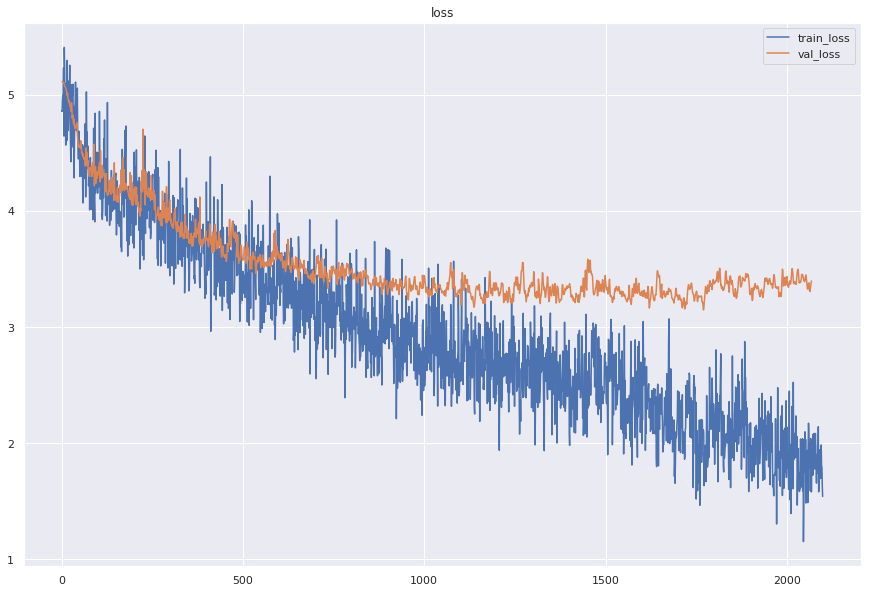

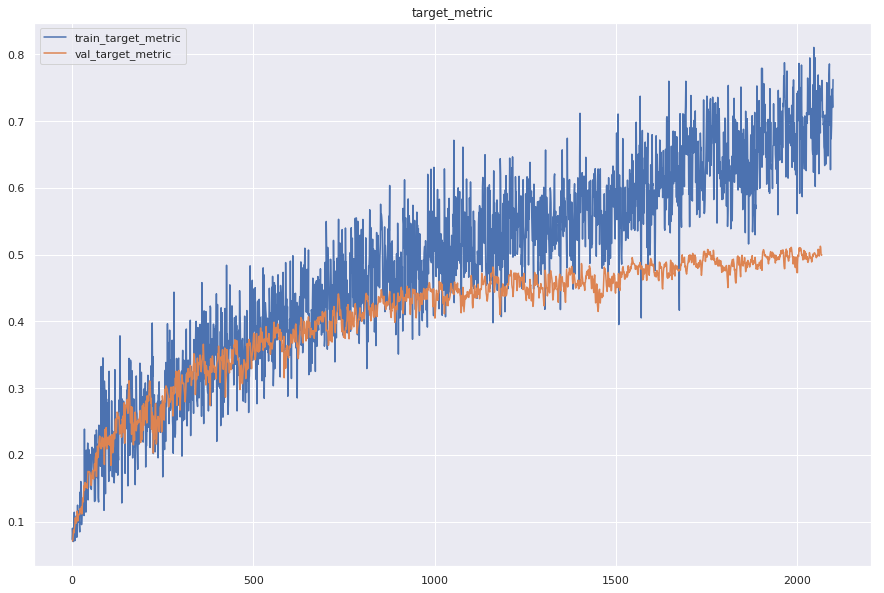

In [16]:
tr.train(
    loaders={"train_loader":train_loader, "test_loader":test_loader},
    params={"epochs":10, "grad_clip_norm":10.0, "validate_every":25},
)